# Access to Care

In [37]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt


In [38]:
df = pd.read_csv('Access_to_Care_Dataset.csv')

## Data Cleaning

In [39]:
df_clean = df[
    (~df["GROUP"].isin(["Total", "Age groups with 75 years and older"])) &
    (df["ESTIMATE"].notna())
].copy()


## Feature Engineering
Define risk of falling through the cracks by 3 dimensions

In [40]:
variables = [
    # Barrier
    "Did not get needed medical care due to cost",
    "Delayed getting medical care due to cost among adults",
    "Any difficulty communicating",
    "Did not take medication as prescribed to save money",
    "Has a usual place of care among adults",

    # Persistence
    "Functioning difficulties status (composite) among adults",
    "Fair or poor health status in adults",

    # Spillover
    "Six or more workdays missed due to illness, injury, or disability"
]


In [41]:
df_var = df_clean[df_clean["TOPIC"].isin(variables)]
df_var.head()

,TOPIC,SUBTOPIC,SUBTOPIC_ID,TAXONOMY,TAXONOMY_ID,CLASSIFICATION,CLASSIFICATION_ID,GROUP,GROUP_ID,GROUP_ORDER,...,ESTIMATE_TYPE,ESTIMATE_TYPE_ID,TIME_PERIOD,TIME_PERIOD_ID,ESTIMATE,STANDARD_ERROR,ESTIMATE_LCI,ESTIMATE_UCI,FLAG,FOOTNOTE_ID_LIST
942,Any difficulty communicating,NaN,NaN,Functioning and disability,100,Demographic Characteristic,1,Age groups with 65 years and older,2,2,...,"Percent of population, crude",1,2019,NaN,4.4,NaN,3.8,5.1,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA43,SC_NHISA00"
943,Any difficulty communicating,NaN,NaN,Functioning and disability,100,Demographic Characteristic,1,Age groups with 65 years and older,2,2,...,"Percent of population, crude",1,2020,NaN,4.3,NaN,3.6,5.1,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA43,SC_NHISA00"
944,Any difficulty communicating,NaN,NaN,Functioning and disability,100,Demographic Characteristic,1,Age groups with 65 years and older,2,2,...,"Percent of population, crude",1,2021,NaN,4.7,NaN,4.0,5.5,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA43,SC_NHISA00"
945,Any difficulty communicating,NaN,NaN,Functioning and disability,100,Demographic Characteristic,1,Age groups with 65 years and older,2,2,...,"Percent of population, crude",1,2022,NaN,5.3,NaN,4.5,6.1,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA43,SC_NHISA00"
946,Any difficulty communicating,NaN,NaN,Functioning and disability,100,Demographic Characteristic,1,Age groups with 65 years and older,2,2,...,"Percent of population, crude",1,2023,NaN,6.0,NaN,5.3,6.8,NaN,"NT_NHISA00,NT_NHISA999,FN_NHISA43,SC_NHISA00"


In [42]:
X = (
    df_var
    .pivot_table(
        index=["GROUP", "SUBGROUP"],
        columns="TOPIC",
        values="ESTIMATE",
        aggfunc="mean"
    )
)


In [43]:
protective_vars = [
    "Has a usual place of care among adults"
]

for v in protective_vars:
    if v in X.columns:
        X[v] = -X[v]


In [44]:
X.isnull().sum()

TOPIC
Any difficulty communicating                                         2
Delayed getting medical care due to cost among adults                0
Did not get needed medical care due to cost                          1
Did not take medication as prescribed to save money                  1
Fair or poor health status in adults                                 1
Functioning difficulties status (composite) among adults             0
Has a usual place of care among adults                               0
Six or more workdays missed due to illness, injury, or disability    2
dtype: int64

In [45]:
X_filled = X.copy()
X_filled = X_filled.fillna(X.mean())

In [46]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_filled)


## Modelling
Use elbow method to find reasonable k

In [47]:
inertia = []
K = range(2, 9)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    km.fit(X_scaled)
    inertia.append(km.inertia_)


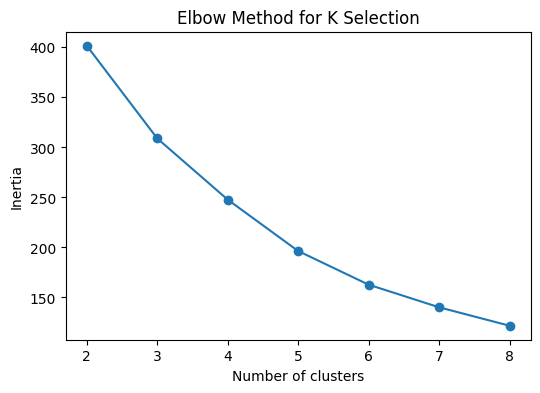

In [48]:
plt.figure(figsize=(6,4))
plt.plot(K, inertia, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method for K Selection")
plt.show()


In [49]:
k = 5  
kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
clusters = kmeans.fit_predict(X_scaled)

X_clustered = X_filled.copy()
X_clustered["cluster"] = clusters


## Find the most vulnerable cluster by ranking

In [50]:
cluster_centers = (
    X_clustered
    .groupby("cluster")
    .mean()
)


In [51]:
ranked = cluster_centers.rank(ascending=True)
ranked["total_rank_score"] = ranked.sum(axis=1)

ranked.sort_values("total_rank_score")


TOPIC,Any difficulty communicating,Delayed getting medical care due to cost among adults,Did not get needed medical care due to cost,Did not take medication as prescribed to save money,Fair or poor health status in adults,Functioning difficulties status (composite) among adults,Has a usual place of care among adults,"Six or more workdays missed due to illness, injury, or disability",total_rank_score
cluster,,,,,,,,,
0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,3.0,18.0
1,4.0,1.0,1.0,1.0,4.0,4.0,1.0,2.0,18.0
2,1.0,5.0,5.0,5.0,1.0,1.0,5.0,1.0,24.0
3,3.0,3.0,3.0,3.0,3.0,3.0,4.0,4.0,26.0
4,5.0,4.0,4.0,4.0,5.0,5.0,2.0,5.0,34.0


In [52]:
most_vulnerable_cluster = ranked["total_rank_score"].idxmin()
print("Most vulnerable cluster:", most_vulnerable_cluster)


Most vulnerable cluster: 0


In [53]:
vuln = X_clustered[X_clustered["cluster"] == most_vulnerable_cluster]


## Find the most vulnerable subgroup in the most vulnerable cluster

In [54]:
vuln["risk_score"] = vuln.drop(columns="cluster").mean(axis=1)


In [57]:
vuln_reset = vuln.reset_index()

top_subgroups = (
    vuln_reset.loc[
        vuln_reset.groupby("GROUP")["risk_score"].idxmax()
    ]
    .sort_values("risk_score", ascending=False)
)



In [58]:
top_subgroups

TOPIC,GROUP,SUBGROUP,Any difficulty communicating,Delayed getting medical care due to cost among adults,Did not get needed medical care due to cost,Did not take medication as prescribed to save money,Fair or poor health status in adults,Functioning difficulties status (composite) among adults,Has a usual place of care among adults,"Six or more workdays missed due to illness, injury, or disability",cluster,risk_score
5,Education,High school diploma or GED,7.116667,8.550000,7.850000,8.266667,20.083333,50.350000,-86.666667,15.683333,0,3.904167
44,Urbanicity,Nonmetropolitan,7.150000,8.383333,7.483333,8.600000,19.650000,52.583333,-90.233333,15.716667,0,3.666667
15,Metropolitan statistical area,Non-MSA,7.150000,8.316667,7.416667,8.566667,19.533333,52.550000,-90.200000,15.750000,0,3.635417
21,Race,Black only,6.683333,8.400000,8.300000,10.483333,19.166667,42.316667,-86.000000,14.683333,0,3.004167
26,Race and Hispanic origin,"Black only, non-Hispanic",6.683333,8.366667,8.333333,10.433333,19.133333,42.333333,-86.116667,14.766667,0,2.991667
31,Region,South,5.816667,9.283333,8.483333,9.450000,16.183333,44.816667,-85.583333,14.233333,0,2.835417
37,Social vulnerability,High social vulnerability,5.766667,8.266667,7.733333,8.650000,17.616667,43.516667,-85.916667,14.133333,0,2.470833
2,Age groups with 65 years and older,50-64 years,4.550000,8.616667,7.900000,8.550000,18.816667,48.233333,-92.300000,15.016667,0,2.422917
35,Sexual orientation,Gay or Lesbian,5.380000,8.916667,8.016667,8.950000,11.700000,44.366667,-87.866667,16.050000,0,1.939167
33,Sex,Female,5.100000,8.700000,7.700000,8.800000,15.033333,45.450000,-91.200000,15.916667,0,1.937500
